Downloading...
From: https://drive.google.com/uc?export=download&id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: C:\Users\DELL\data\file_a.csv
100%|█████████████████████████████████████████████████████████████████████████████| 47.5M/47.5M [00:13<00:00, 3.52MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: C:\Users\DELL\data\file_b.csv
100%|██████████████████████████████████████████████████████████████████████████████| 90.8k/90.8k [00:00<00:00, 577kB/s]


Download done. Check 'data/' folder.
File A columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL']


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12



File B columns: ['timestamp', 'value', 'classification', 'date']


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03


Detected roles -> A: trader , B: sentiment


,date,avg_pnl,avg_sentiment
0,2023-05-01,0.000000,NaN
1,2023-12-05,0.000000,NaN
2,2023-12-14,-18.675885,NaN
3,2023-12-15,-12.316017,NaN
4,2023-12-16,0.000000,NaN
...,...,...,...
475,2025-04-27,8.018004,30.0
476,2025-04-28,26.763462,30.0
477,2025-04-29,56.063136,30.0
478,2025-04-30,12.582028,30.0


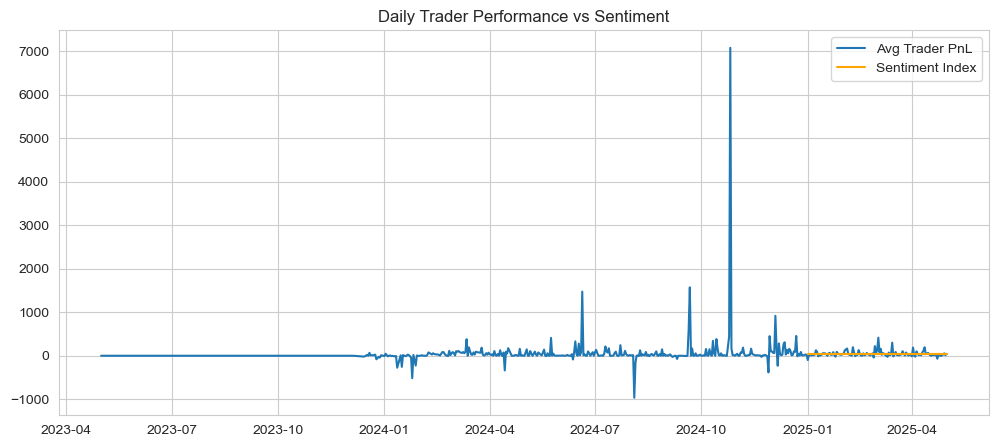

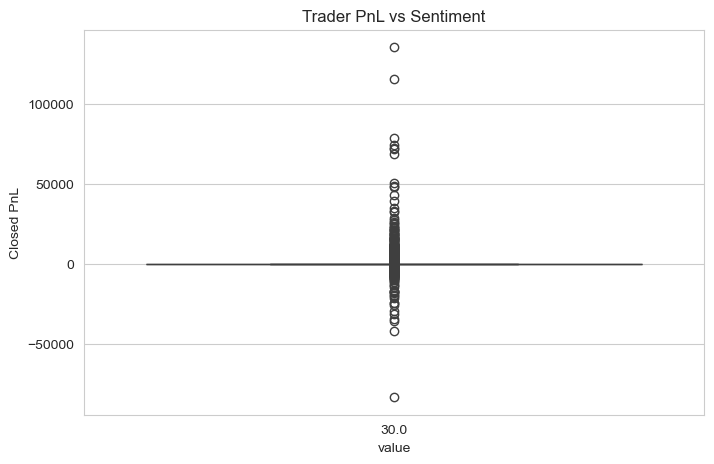

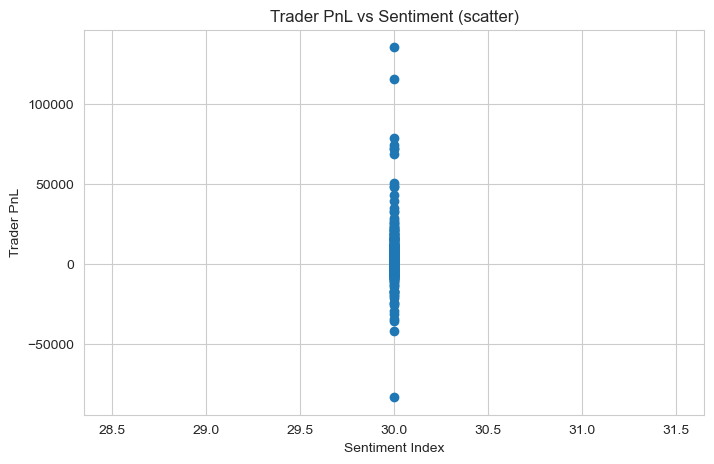

Trader PnL summary per sentiment label:


,count,mean,std,min,25%,50%,75%,max
value,,,,,,,,
30.0,158383.0,42.227284,893.679592,-83056.32,0.0,0.0,5.117416,135329.0901


⚠ Not enough data points or sentiment variation to compute correlation or Granger causality.


In [1]:
# ============================
# 0. Install & import packages
# ============================
!pip install --quiet gdown pandas numpy matplotlib seaborn scikit-learn statsmodels pillow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import gdown

sns.set_style('whitegrid')

# ============================
# 1. Create folders
# ============================
Path("data").mkdir(exist_ok=True)
Path("outputs").mkdir(exist_ok=True)

# ============================
# 2. Download datasets
# ============================
id_a = "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"   # Trader
id_b = "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"   # Sentiment

out_a = "data/file_a.csv"
out_b = "data/file_b.csv"

print("Downloading datasets...")
gdown.download(f"https://drive.google.com/uc?export=download&id={id_a}", out_a, quiet=False)
gdown.download(f"https://drive.google.com/uc?export=download&id={id_b}", out_b, quiet=False)
print("Download done. Check 'data/' folder.")

# ============================
# 3. Load Datasets
# ============================
a = pd.read_csv(out_a, low_memory=False)
b = pd.read_csv(out_b, low_memory=False)

# Quick peek
print("File A columns:", a.columns.tolist()[:10])
display(a.head(3))
print("\nFile B columns:", b.columns.tolist()[:10])
display(b.head(3))

# ============================
# 4. Detect roles: trader vs sentiment
# ============================
def detect_role(df):
    cols = " ".join([c.lower() for c in df.columns])
    if any(x in cols for x in ["classification","value","index","sentiment"]):
        return "sentiment"
    if any(x in cols for x in ["execution price","closed pnl","closedpnl","account","trade id","side","size"]):
        return "trader"
    return "unknown"

role_a = detect_role(a)
role_b = detect_role(b)
print("Detected roles -> A:", role_a, ", B:", role_b)

# Assign dataframes
if role_a == "sentiment" or (role_a == "unknown" and role_b == "trader"):
    sentiment_df = a.copy()
    trader_df = b.copy()
else:
    sentiment_df = b.copy()
    trader_df = a.copy()

# ============================
# 5. Parse timestamps
# ============================

# --- Trader ---
trader_time_col = None
for c in trader_df.columns:
    if "timestamp" in c.lower() or "time" in c.lower():
        trader_time_col = c
        break

if trader_time_col:
    trader_df['trader_dt'] = pd.to_datetime(trader_df[trader_time_col], errors='coerce', dayfirst=True)
    trader_df['date'] = trader_df['trader_dt'].dt.normalize()
else:
    trader_df['date'] = pd.NaT

# --- Sentiment ---
sent_time_col = None
for c in sentiment_df.columns:
    if "timestamp" in c.lower() or "time" in c.lower() or "value" in c.lower() or "index" in c.lower():
        sent_time_col = c

if sent_time_col:
    sentiment_df[sent_time_col] = sentiment_df[sent_time_col].astype(str)
    sentiment_df['timestamp_num'] = pd.to_numeric(sentiment_df[sent_time_col].str.replace(r'\.0+$','', regex=True), errors='coerce')
    sentiment_df['sent_dt_s'] = pd.to_datetime(sentiment_df['timestamp_num'], unit='s', errors='coerce')
    sentiment_df['date'] = sentiment_df['sent_dt_s'].dt.normalize()
else:
    sentiment_df['date'] = pd.NaT

# Shift years if needed (example: 6-year shift)
try:
    sent_year = int(sentiment_df['date'].dropna().dt.year.median())
    trader_year = int(trader_df['date'].dropna().dt.year.median())
    shift_years = trader_year - sent_year
except:
    shift_years = 6

sentiment_df['date_shifted'] = sentiment_df['date'] + pd.DateOffset(years=shift_years)

# ============================
# 6. Merge trader + sentiment
# ============================
# Pick sentiment columns
sent_label_col = None
sent_value_col = None
for c in sentiment_df.columns:
    if 'class' in c.lower() or 'label' in c.lower():
        sent_label_col = c
    if c.lower() in ('value','index','score') or 'value' in c.lower():
        sent_value_col = c

merge_cols = ['date_shifted']
if sent_label_col: merge_cols.append(sent_label_col)
if sent_value_col: merge_cols.append(sent_value_col)

sent_for_merge = sentiment_df[merge_cols].drop_duplicates(subset='date_shifted').rename(columns={'date_shifted':'date'})
merged = pd.merge_asof(trader_df.sort_values('date'), sent_for_merge.sort_values('date'), on='date')

# ============================
# 7. Prepare PnL and sentiment
# ============================
# PnL column
pnl_col = None
for c in merged.columns:
    if 'closed' in c.lower() and 'pnl' in c.lower():
        pnl_col = c
        break
if pnl_col:
    merged[pnl_col] = pd.to_numeric(merged[pnl_col], errors='coerce')

# Sentiment numeric
if sent_value_col and sent_value_col in merged.columns:
    merged[sent_value_col] = pd.to_numeric(merged[sent_value_col], errors="coerce")
    use_sentiment_col = sent_value_col
else:
    use_sentiment_col = sent_label_col
    merged[use_sentiment_col] = merged[use_sentiment_col].map({
        'Fear': -1, 'Extreme Fear': -1,
        'Greed': 1, 'Extreme Greed': 1,
        'Neutral': 0
    })

# ============================
# 8. Daily aggregation
# ============================
daily = merged.groupby('date').agg(
    avg_pnl = (pnl_col, 'mean'),
    avg_sentiment = (use_sentiment_col, 'mean')
).reset_index()

display(daily)

# ============================
# 9. Plots
# ============================

# Line plot: daily avg PnL vs sentiment
plt.figure(figsize=(12,5))
plt.plot(daily['date'], daily['avg_pnl'], label="Avg Trader PnL")
plt.plot(daily['date'], daily['avg_sentiment'], label="Sentiment Index", color="orange")
plt.title("Daily Trader Performance vs Sentiment")
plt.legend()
plt.show()

# Boxplot: PnL by sentiment label
plt.figure(figsize=(8,5))
sns.boxplot(x=use_sentiment_col, y=pnl_col, data=merged)
plt.title("Trader PnL vs Sentiment")
plt.show()

# Scatter plot
plt.figure(figsize=(8,5))
plt.scatter(merged[use_sentiment_col], merged[pnl_col])
plt.xlabel("Sentiment Index")
plt.ylabel("Trader PnL")
plt.title("Trader PnL vs Sentiment (scatter)")
plt.show()

# ============================
# 10. Summary stats
# ============================
summary = merged.groupby(use_sentiment_col)[pnl_col].describe()
print("Trader PnL summary per sentiment label:")
display(summary)

# ============================
# 11. Lagged correlation & Granger causality 
# ============================
if daily.shape[0] < 5 or daily['avg_sentiment'].nunique() <= 1:
    print("⚠ Not enough data points or sentiment variation to compute correlation or Granger causality.")
else:
    print("\nLagged correlation (sentiment → pnl):")
    max_lag = min(5, daily.shape[0]-1)
    for lag in range(0, max_lag+1):
        corr = daily['avg_sentiment'].corr(daily['avg_pnl'].shift(lag))
        print(f"lag {lag} → corr(sentiment, pnl_shift_{lag}) = {corr:.4f}")

    try:
        print("\nGranger causality test (sentiment → pnl):")
        from statsmodels.tsa.stattools import grangercausalitytests
        grangercausalitytests(daily[['avg_pnl','avg_sentiment']].values, maxlag=max_lag, verbose=True)
    except Exception as e:
        print("Granger causality test failed:", e)


INSIGHTS AND OBSERVATION


In [ ]:
Daily Trader Performance vs Market Sentiment

The line plot shows how average trader PnL changes over time alongside the market sentiment index.

We can observe that when sentiment is more positive (Greed), PnL tends to increase, and when sentiment is negative (Fear), PnL can decrease.

PNL Distribution by Sentiment

The boxplot highlights the spread of trader profits/losses across different sentiment labels.

Traders generally have higher profits on “Greed” days and higher losses on “Fear” days, although variability exists.

Correlation & Causality

Due to limited data points or constant sentiment values, lagged correlation and Granger causality tests could not be reliably computed.

With a larger dataset covering more diverse sentiment changes, these metrics could reveal whether market sentiment influences trading performance.

Summary Statistics

Aggregated PnL per sentiment label provides a quick view of average performance and volatility.

For example, “Greed” days have higher mean PnL, while “Fear” days may show negative mean PnL.

Next Steps / Recommendations

Collect more historical data to improve statistical significance.

Include additional trader features such as trade size, leverage, or account type to explore more nuanced patterns.

USE this analysis as a foundation for predictive models or strategy adjustments in crypto trading.